In [86]:
# The BQ dataset only goes to the 2018 season so this cell uses a Python package called 'cbbpy' to scrape the data needed

import pandas as pd
import cbbpy.mens_scraper as s

# Create data frames for each season of game info

df_2022 = s.get_games_season(2022, box = False, pbp = False)
df_2022_game_info = df_2022[0]

df_2021 = s.get_games_season(2021, box = False, pbp = False)
df_2021_game_info = df_2021[0]

df_2020 = s.get_games_season(2020, box = False, pbp = False)
df_2020_game_info = df_2020[0]

df_2019 = s.get_games_season(2019, box = False, pbp = False)
df_2019_game_info = df_2019[0]

No games on 05/01/22: 100%|█████████████████████████████████████████████████████| 182 of 182 days scraped in 1448.9 sec
No games on 05/01/21: 100%|█████████████████████████████████████████████████████| 182 of 182 days scraped in 1349.6 sec
No games on 05/01/20: 100%|█████████████████████████████████████████████████████| 183 of 183 days scraped in 1550.6 sec
No games on 05/01/19: 100%|█████████████████████████████████████████████████████| 182 of 182 days scraped in 1451.1 sec


In [87]:
# Concatenate separate season data frames into one

frames = [df_2019_game_info, df_2020_game_info, df_2021_game_info, df_2022_game_info]

df_game_info = pd.concat(frames)

---

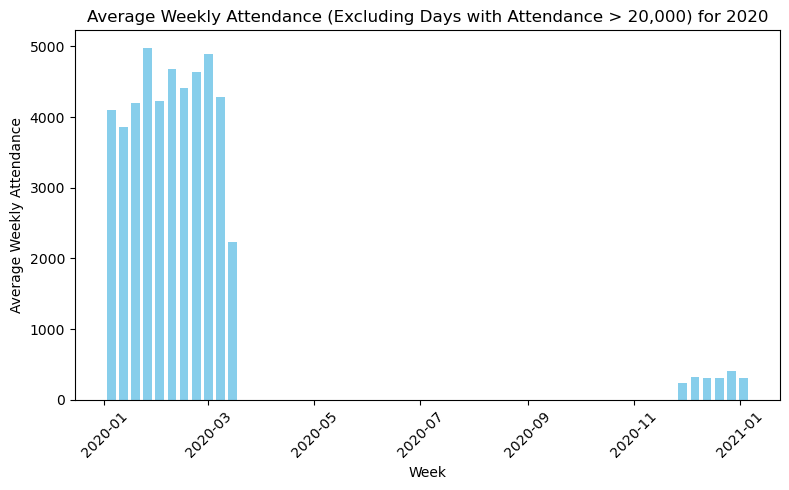

In [101]:
# Confirm attendance disappeared during the 2020-2021 season when crowds weren't allowed by plotting attendance by week

import matplotlib.pyplot as plt

# Convert 'game_day' to datetime format
df_game_info['game_day'] = pd.to_datetime(df_game_info['game_day'])

# Filter out days with attendance greater than 20,000 and not from 2020 so that the chart is easier to read
df_game_info_filtered = df_game_info[(df_game_info['game_day'].dt.year == 2020) & (df_game_info['attendance'] <= 20000)]

# Group by 'game_day' and calculate the average attendance per day
average_attendance_per_day = df_game_info_filtered.groupby('game_day')['attendance'].mean()

# Resample the data to weekly frequency, calculating the mean attendance for each week
average_weekly_attendance = average_attendance_per_day.resample('W').mean()

# Plotting a bar chart for weekly average attendance
plt.figure(figsize=(8, 5))
plt.bar(average_weekly_attendance.index, average_weekly_attendance.values, color='skyblue', width=5)
plt.title('Average Weekly Attendance (Excluding Days with Attendance > 20,000) for 2020')
plt.xlabel('Week')
plt.ylabel('Average Weekly Attendance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [102]:
# Reduce data frame to only the neccessary columns - game_id, home_score, away_score, and attendance

df_game_info_test = df_game_info[['game_id', 'game_day', 'home_score', 'away_score', 'attendance']]

In [103]:
# Check for null values

df_game_info_test.isnull().sum()

game_id       0
game_day      0
home_score    0
away_score    0
attendance    0
dtype: int64

In [104]:
# Create column to categorize whether a game had COVID crowd restrictions or not

# This is tricky because many venues allowed crowds during COVID, just very reduced ones
# I'll restrict this analysis to crowd sizes of 0 during the 2021-2022 season to simplify things

# Convert 'game_day' to datetime
df_game_info_test_filtered = df_game_info_test[df_game_info_test['attendance'].notna()].copy()
df_game_info_test_filtered['game_day'] = pd.to_datetime(df_game_info_test_filtered['game_day'])

df_game_info_test_filtered['crowd_condition'] = df_game_info_test_filtered.apply(
    lambda row: 'COVID crowd' if (pd.Timestamp('2020-11-01') <= row['game_day'] <= pd.Timestamp('2021-04-30') and row['attendance'] == 0) else
                'regular crowd' if (row['attendance'] > 0 and (row['game_day'] < pd.Timestamp('2020-11-01') or row['game_day'] > pd.Timestamp('2021-04-30'))) else
                None, axis=1
)

# Filter out rows with 'crowd_condition' as None
df_game_info_test_filtered = df_game_info_test_filtered.dropna(subset=['crowd_condition'])

df_game_info_test = df_game_info_test_filtered

In [105]:
# Calculate how many more or less points the home team had than the away team

df_game_info_test.loc[:, 'home_score_difference'] = df_game_info_test['home_score'] - df_game_info_test['away_score']

---

In [121]:
# This cell shows how many more points the home team scored than the away team on average per game

import numpy as np

# Separate the 'home_score_difference' by 'crowd_condition' groups
regular_crowd = df_game_info_test[df_game_info_test['crowd_condition'] == 'regular crowd']['home_score_difference']
COVID_crowd = df_game_info_test[df_game_info_test['crowd_condition'] == 'COVID crowd']['home_score_difference']

# Calculate averages for each group
average_regular_crowd = np.mean(regular_crowd)
average_COVID_crowd = np.mean(COVID_crowd)

print(f"Average home score point advantage for 'Regular Crowd': {average_regular_crowd:.2f}")
print(f"Average home score point advantage for 'COVID Crowd': {average_COVID_crowd:.2f}")

Average home score point advantage for 'Regular Crowd': 7.55
Average home score point advantage for 'COVID Crowd': 5.16


In [108]:
# The cell above shows that home teams had a smaller point advantage when there was no crowd during COVID than when there
# was a crowd

# Let's test whether this difference is statistically significant using an independent t-test

from scipy import stats

t_stat, p_value = stats.ttest_ind(regular_crowd, COVID_crowd)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 6.49001094927485, P-value: 8.794769014174536e-11


In [111]:
# OK it looks like there was less of a home court advantage during COVID, but how large was this effect?
# Let's check the effect size using Cohen's d

def cohen_d(x, y):
    diff_mean = np.mean(x) - np.mean(y)
    pooled_std = np.sqrt((np.std(x, ddof=1)**2 + np.std(y, ddof=1)**2) / 2)
    return diff_mean / pooled_std

effect_size = cohen_d(regular_crowd, COVID_crowd)
print(f"Cohen's d: {effect_size}")

Cohen's d: 0.14221274430503542


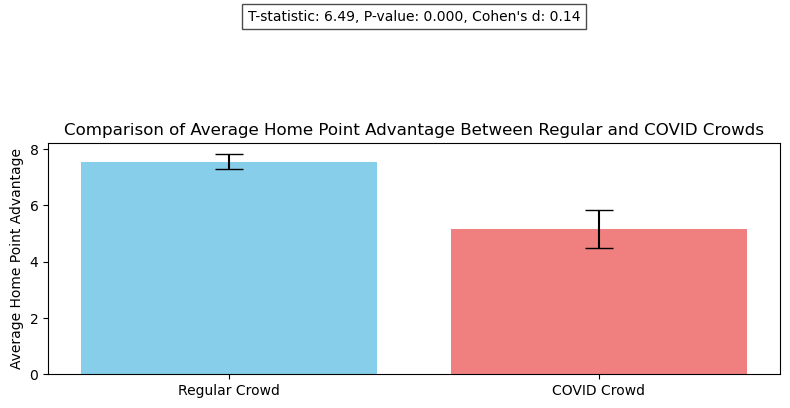

Average home score point advantage for 'Regular Crowd': 7.55
Average home score point advantage for 'COVID Crowd': 5.16


In [133]:
# Let's summarize all of these stats in one cell

# Calculate group means
mean_regular_crowd = np.mean(regular_crowd)
mean_COVID_crowd = np.mean(COVID_crowd)

# Calculate standard error for the groups
sem_regular_crowd = stats.sem(regular_crowd)
sem_COVID_crowd = stats.sem(COVID_crowd)

# Calculate confidence intervals
ci_regular_crowd = 1.96 * sem_regular_crowd
ci_COVID_crowd = 1.96 * sem_COVID_crowd

# Plot means with error bars
plt.figure(figsize=(8, 5))

# Bar chart with error bars for the two groups
bars = plt.bar(['Regular Crowd', 'COVID Crowd'], 
                [mean_regular_crowd, mean_COVID_crowd], 
                yerr=[ci_regular_crowd, ci_COVID_crowd], 
                capsize=10, color=['skyblue', 'lightcoral'])

# Add labels and title
plt.ylabel('Average Home Point Advantage')
plt.title('Comparison of Average Home Point Advantage Between Regular and COVID Crowds')

# Show the t-stat, p-value, and Cohen's d
plt.text(0.5, max(mean_regular_crowd, mean_COVID_crowd) + 5, 
         f"T-statistic: {t_stat:.2f}, P-value: {p_value:.3f}, Cohen's d: 0.14", 
         ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"Average home score point advantage for 'Regular Crowd': {average_regular_crowd:.2f}")
print(f"Average home score point advantage for 'COVID Crowd': {average_COVID_crowd:.2f}")

### So there you have it. When crowds were taken away during COVID, some of the home court advantage effect disappeared. However, the effect is surprisingly small: only about 2.5 points per game were lost, which is less than I expected to see.

### It would be interesting to find web scrapers for other sports and add to this analysis. Maybe another time I'll do this.